# Stanford Stats 191

## Introduction

This is a re-creation of the Stanford Stats 191 course (see https://web.stanford.edu/class/stats191/), using Python eco-system tools, instead of R. This is lecture "Transformations and Weighted Least Squares"


## Initial Notebook Setup

```watermark ``` documents the current Python and package environment, ```black``` is my preferred Python formatter

In [2]:
%load_ext watermark

In [3]:
%load_ext lab_black

In [4]:
%matplotlib inline

All import got here (not all are used in this Notebook)

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
from statsmodels.formula.api import mixedlm
from statsmodels.formula.api import wls
import statsmodels.api as sm

from patsy import dmatrices

from patsy.contrasts import Treatment
from patsy.contrasts import Sum
from patsy.contrasts import Diff


import warnings

---------------

## Nonlinear Models

We look at a dataset where a linear model is not appropriate

### Load and Explore Dataset

In [6]:
data = pd.read_csv('../data/bacteria.txt', sep='\t')

In [7]:
data.head()

,t,N_t
0,1,355
1,2,211
2,3,197
3,4,166
4,5,142


Text(0, 0.5, 'Count')

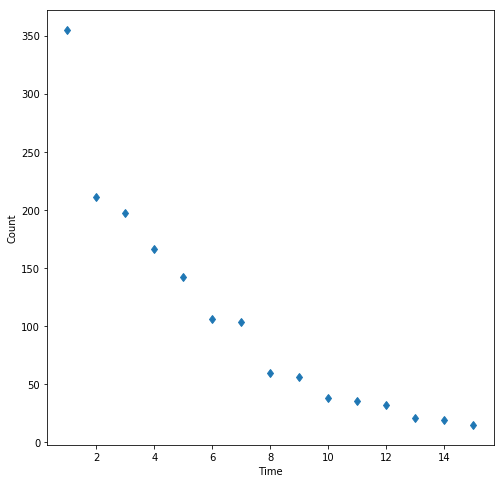

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(data['t'], data['N_t'], 'd')
ax.set_xlabel('Time')
ax.set_ylabel('Count')

------------
### Fit a Linear Model

In [9]:
res1 = ols('N_t ~ t', data=data).fit()
res1.summary()

D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    N_t   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     60.62
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           3.01e-06
Time:                        16:42:55   Log-Likelihood:                -76.216
No. Observations:                  15   AIC:                             156.4
Df Residuals:                      13   BIC:                             157.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    259.5810     22.730     11.420      0.000     210.476     308.686
t            -19.4643      2.500     -7.786      0.000     -24.865     -14.063
==============================================================================
Omnibus:                       14.123   Durbin-Watson:                   0.803
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               10.490
Skew:                           1.648   Prob(JB):                      0.00527
Kurtosis:                       5.432   Cond. No.                         19.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Visualize the fit of our linear model to the data

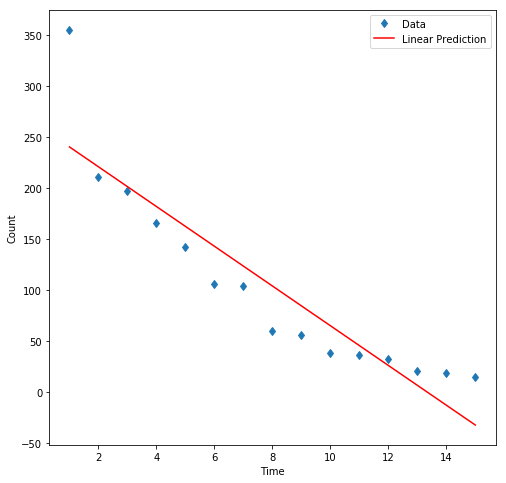

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(data['t'], data['N_t'], 'd', label='Data')
ax.plot(
    data['t'],
    res1.predict(),
    'r-',
    label='Linear Prediction',
)

ax.set_xlabel('Time')
ax.set_ylabel('Count')

ax.legend(loc='best')

### Regression Diagnostics

The STATS191 lecture notes have  quartet of plots that can be used to assess linear model quality. We define a function to show these, given the RegressionResults object from a ```ols``` model fit

In [77]:
def show_regression_diagnostic_plots(res1):
    '''
    show_regression_diagnostic_plots: show four plots to assess validity of linear regression
    
    Refer to https://web.stanford.edu/class/stats191/notebooks/Transformations_WLS.html for examples
    that guided this function
    
    Parameters
    res1: statsmodels RegressionResults value
    
    Returns
    matplotlib Figure object containing plots (one in each Axes object linked to Figure object)
    
    Notes
    In a Jupyter Notebook, calling this function will display a Figure, and also return a Figure
    Just a naked call will result in the plots being displayed twice.  To prevent this, assign
    the function call return to a variable
    '''

    fig, ax = plt.subplots(
        nrows=2,
        ncols=2,
        figsize=(10, 10),
        constrained_layout=True,
    )

    # create a qq plot, to assess how (if) the residuals are distributed
    axr1c2 = ax[0, 1]
    sm.qqplot(res1.resid, line='s', ax=axr1c2)
    axr1c2.set_title('Normal QQ Plot')

    # plot residuals against  fitted value, to see if residuals are correlated with exog variable
    # (i.e. are not normally distributed)
    axr1c1 = ax[0, 0]
    axr1c1.plot(res1.predict(), res1.resid, 'rd')
    axr1c1.set_xlabel('Fitted Values')
    axr1c1.set_ylabel('Residuals')
    axr1c1.axhline(0, color='k')
    axr1c1.set_title('Residuals vs Fitted')

    # plot standardizerd residuals against leverage
    axr2c2 = ax[1, 1]
    influence = res1.get_influence()
    hat = influence.hat_matrix_diag
    standardized_residuals_int = (
        influence.resid_studentized_internal
    )
    axr2c2.plot(hat, standardized_residuals_int, 'd')
    axr2c2.set_xlabel('Leverage')
    axr2c2.set_ylabel('Standardised Residuals')
    axr2c2.set_title('Residuals vs Leverage')

    axr2c1 = ax[1, 0]
    standardized_residuals_ext = (
        influence.resid_studentized_external
    )
    zz = np.sqrt(np.abs(standardized_residuals_ext))
    axr2c1.plot(res1.predict(), zz, 'rd', label='Data')
    axr2c1.set_xlabel('Fitted Values')
    axr2c1.set_ylabel(
        'sqrt(abs(Externally Studentized Residual))'
    )
    axr2c1.set_title('Scale-Location')

    return fig


# end

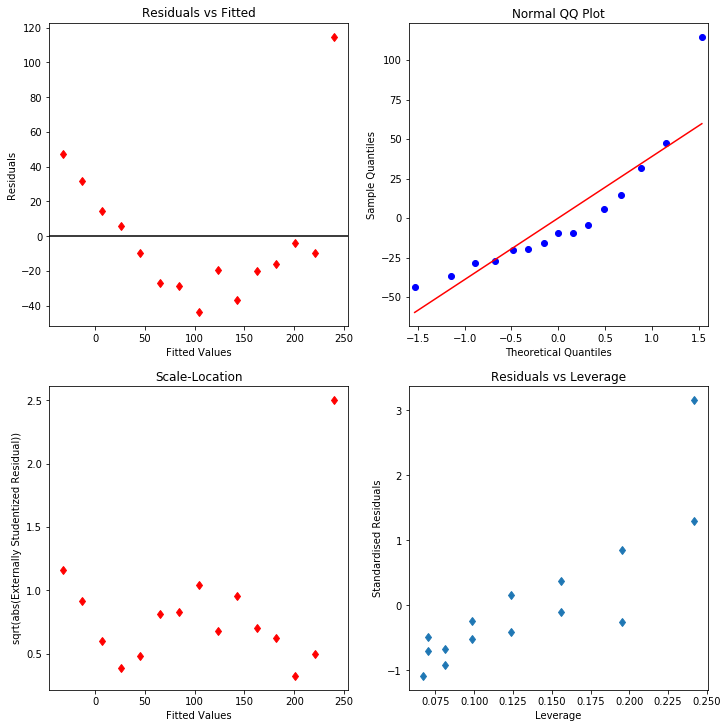

In [76]:
fig = show_regression_diagnostic_plots(res1)

We see that residuals are clearly __not__ distributed uniformly (Residuals vs Fitted graph).

Further, if we look at the ```statsmodels``` influence and leverage graphs, we see a clear outlier

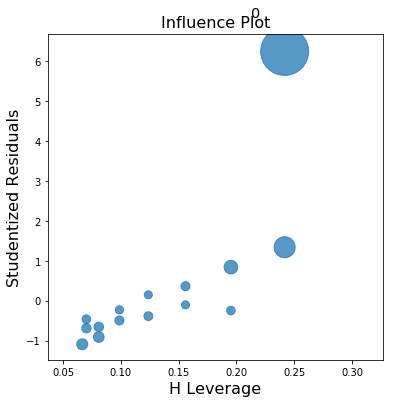

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))

_ = sm.graphics.influence_plot(res1, ax=ax)

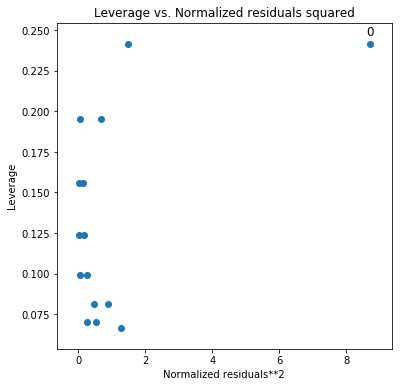

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))

_ = sm.graphics.plot_leverage_resid2(res1, ax=ax)

------------------
## Fit Exponential

At this stage we decide that a better model might be that of exponential decay, where the log of ```N_t``` might be linear in time.

Note that we can use ```numpy``` functions inside the ```ols``` formula

In [15]:
res2 = ols('np.log(N_t) ~ t', data=data).fit()
res2.summary()

D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(N_t)   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     1104.
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           5.86e-14
Time:                        16:42:57   Log-Likelihood:                 12.896
No. Observations:                  15   AIC:                            -21.79
Df Residuals:                      13   BIC:                            -20.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9732      0.060     99.922      0.000       5.844       6.102
t             -0.2184      0.007    -33.222      0.000      -0.233      -0.204
==============================================================================
Omnibus:                        0.024   Durbin-Watson:                   2.659
Prob(Omnibus):                  0.988   Jarque-Bera (JB):                0.204
Skew:                          -0.074   Prob(JB):                        0.903
Kurtosis:                       2.448   Cond. No.                         19.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-----
### Assess Exponential Model

Plotting the model predictions against actuals in two different ways, we can see we have a much better fit (also the R^2 value is much closer to 1.0)

Text(0, 0.5, 'Count')

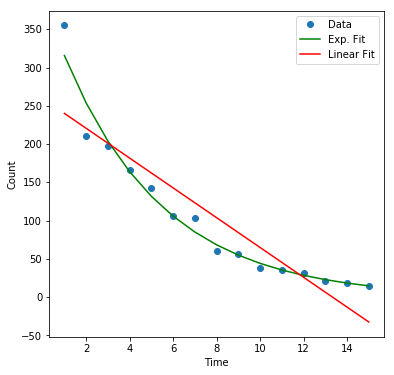

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(data['t'], data['N_t'], 'o', label='Data')
ax.plot(
    data['t'],
    np.exp(res2.predict()),
    'g-',
    label='Exp. Fit',
)
ax.plot(data['t'], res1.predict(), 'r-', label='Linear Fit')
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Count')

D:\Anaconda3\envs\ac5-py37\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


Text(0, 0.5, 'Log Count (ln)')

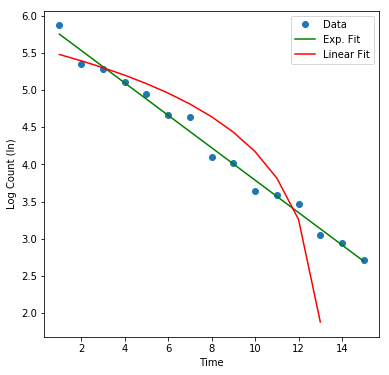

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(data['t'], np.log(data['N_t']), 'o', label='Data')
ax.plot(data['t'], (res2.predict()), 'g-', label='Exp. Fit')
ax.plot(
    data['t'],
    np.log(res1.predict()),
    'r-',
    label='Linear Fit',
)
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Log Count (ln)')

The Diagnostic Graphs look better too (especially Residuals vs Fitted)

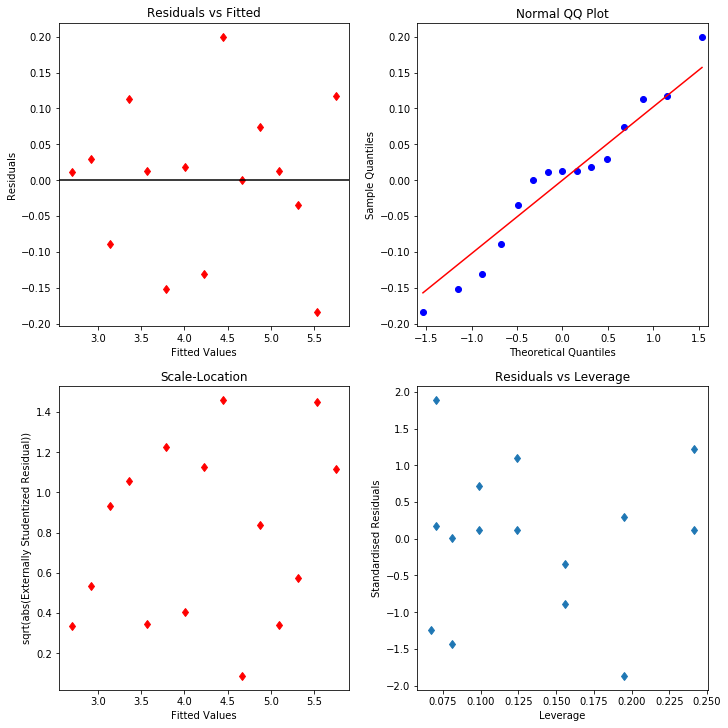

In [18]:
fig = show_regression_diagnostic_plots(res2)

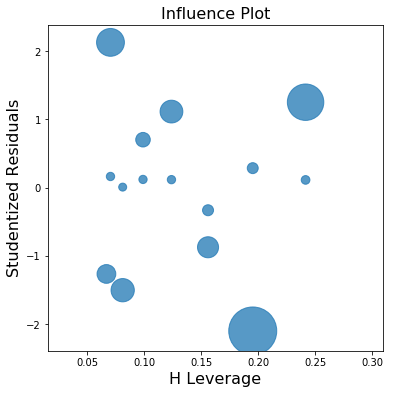

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))

_ = sm.graphics.influence_plot(res2, ax=ax)

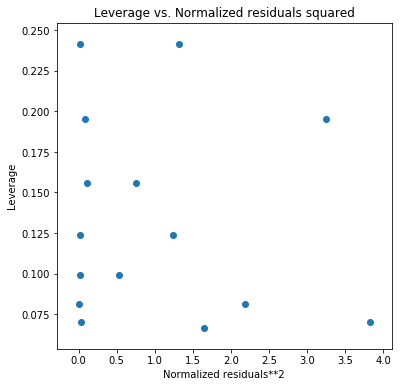

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))

_ = sm.graphics.plot_leverage_resid2(res2, ax=ax)

-------------
## Non-Constant Variance

We now look at a dataset, with an error term that is __not__ constant from observation to observation (see below for description of the dataset)



|Variable|	Description|
|--|--|
Y |	Per capita education expenditure by state
X1 |	Per capita income in 1973 by state
X2 |	Proportion of population under 18
X3 |	Proportion in urban areas
Region|	Which region of the country are the states located in


### Read and Explore Dataset

In [21]:
data2 = pd.read_csv('../data/education1975.txt', sep='\t')

In [22]:
data2.head()

,STATE,Y,X1,X2,X3,Region
0,ME,235,3944,325,508,1
1,NH,231,4578,323,564,1
2,VT,270,4011,328,322,1
3,MA,261,5233,305,846,1
4,RI,300,4780,303,871,1


Annoyingly, we have trailing spaces in the column names, so lets fix those

In [23]:
data2.columns

Index(['STATE ', 'Y ', 'X1 ', 'X2 ', 'X3 ', 'Region  '], dtype='object')

In [24]:
new_names = [n.strip() for n in data2.columns]
data2.columns = new_names
data2.head(1)

,STATE,Y,X1,X2,X3,Region
0,ME,235,3944,325,508,1


In [25]:
data2.describe()

,Y,X1,X2,X3,Region
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,284.600000,4675.120000,325.740000,657.800000,2.660000
std,61.340136,644.506254,19.423119,145.016396,1.061574
min,208.000000,3448.000000,287.000000,322.000000,1.000000
25%,234.250000,4137.250000,310.750000,546.750000,2.000000
50%,269.500000,4706.000000,324.500000,662.500000,3.000000
75%,316.750000,5054.250000,333.000000,782.250000,3.750000
max,546.000000,5889.000000,386.000000,909.000000,4.000000


### Fit Linear Model

In [26]:
res3 = ols('Y ~ X1 + X2 + X3', data=data2).fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     22.19
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           4.94e-09
Time:                        16:43:02   Log-Likelihood:                -253.89
No. Observations:                  50   AIC:                             515.8
Df Residuals:                      46   BIC:                             523.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -556.5680    123.195     -4.518      0.000    -804.547    -308.589
X1             0.0724      0.012      6.239      0.000       0.049       0.096
X2             1.5521      0.315      4.932      0.000       0.919       2.185
X3            -0.0043      0.051     -0.083      0.934      -0.108       0.099
==============================================================================
Omnibus:                        0.719   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.698   Jarque-Bera (JB):                0.760
Skew:                           0.264   Prob(JB):                        0.684
Kurtosis:                       2.705   Cond. No.                     1.03e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Assess Model

The Residuals vs Fitted graph shows a clear increase in residual, as the fitted value increases  (i.e. variance of the error term is __not__ constant)

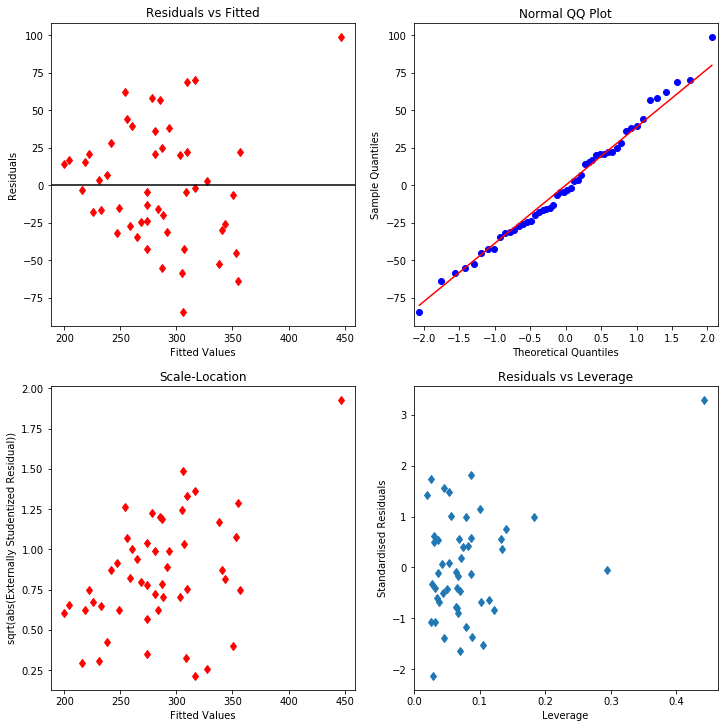

In [27]:
fig = show_regression_diagnostic_plots(res3)

Further, we appear to have an outlier observation (the State of Alaska, code AK)

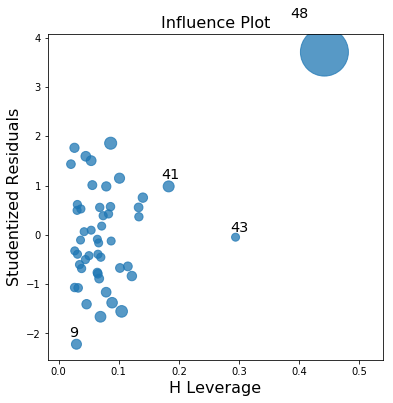

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))

_ = sm.graphics.influence_plot(res3, ax=ax)

In [29]:
data2.iloc[48]

STATE      AK 
Y          546
X1        5613
X2         386
X3         484
Region       4
Name: 48, dtype: object

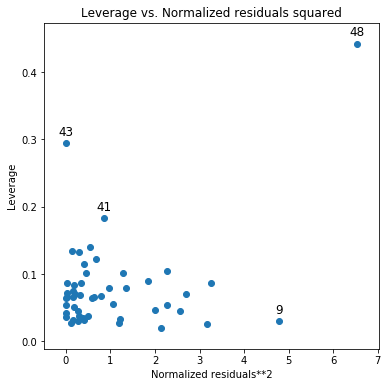

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))

_ = sm.graphics.plot_leverage_resid2(res3, ax=ax)

We now visualize the residuals (standardized) by region, and it appears that each region has a different variance of the error term

Text(0.5, 1.0, 'Standardized Residuals by Region')

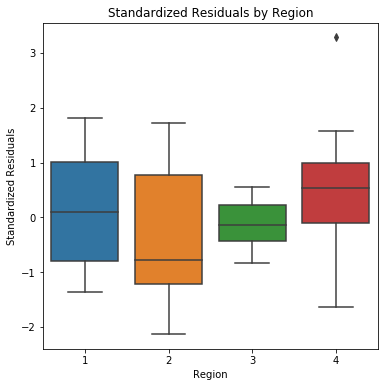

In [78]:
fig, ax = plt.subplots(figsize=(6, 6))

influence = res3.get_influence()
standardized_residuals_int = (
    influence.resid_studentized_internal
)
sns.boxplot(
    'Region', standardized_residuals_int, data=data2, ax=ax
)
ax.set_ylabel('Standardized Residuals')
ax.set_title('Standardized Residuals by Region')

Annoyingly, we find the state codes also have a trailing space, so fix these

In [34]:
'*' + data2['STATE'].iloc[48] + '*'

'*AK *'

In [35]:
data2['STATE'] = data2['STATE'].str.strip()
'*' + data2['STATE'].iloc[48] + '*'

'*AK*'

We now clean the dataset, by excluding the state of Alaska, and making a copy of the DataFrame.

We then fit a linear model again

In [36]:
data2_clean = data2[data2['STATE'] != 'AK'].copy()
print(f'Clean data items {len(data2_clean)}')
res4 = ols('Y ~ X1 + X2 + X3', data=data2_clean).fit()
res4.summary()

Clean data items 49


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     14.80
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           7.65e-07
Time:                        17:05:11   Log-Likelihood:                -242.77
No. Observations:                  49   AIC:                             493.5
Df Residuals:                      45   BIC:                             501.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -277.5773    132.423     -2.096      0.042    -544.291     -10.864
X1             0.0483      0.012      3.976      0.000       0.024       0.073
X2             0.8869      0.331      2.678      0.010       0.220       1.554
X3             0.0668      0.049      1.354      0.183      -0.033       0.166
==============================================================================
Omnibus:                        0.883   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.643   Jarque-Bera (JB):                0.932
Skew:                           0.289   Prob(JB):                        0.628
Kurtosis:                       2.652   Cond. No.                     1.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

-----------------

### Assess Model

Cleaning the data didn't fix our non_constant variance residuals

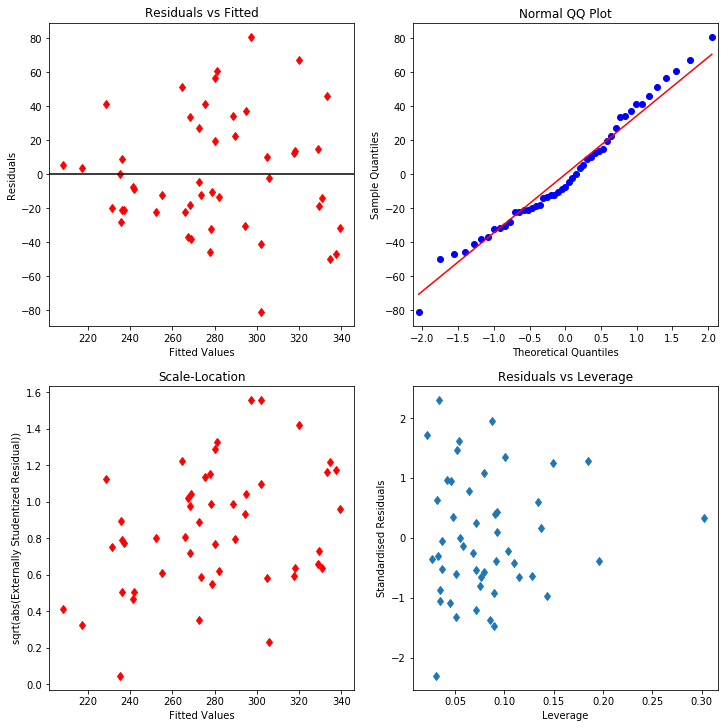

In [39]:
_ = show_regression_diagnostic_plots(res4)

Residuals by Region still show inter-Region difference

Text(0.5, 1.0, 'Standardized Residuals by Region')

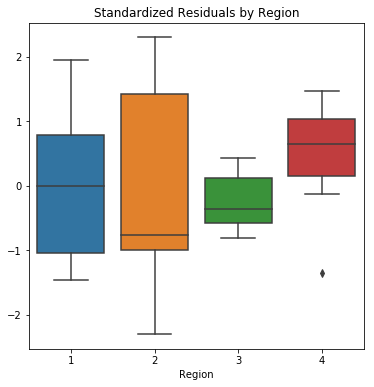

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))

influence = res4.get_influence()
standardized_residuals_int = (
    influence.resid_studentized_internal
)
sns.boxplot(
    'Region',
    standardized_residuals_int,
    data=data2_clean,
    ax=ax,
)
ax.set_title('Standardized Residuals by Region')

-------
## Weighted Least Squares

We define a new model, where we standardized variance by weighting with value of Y  (assumes a model of error term as N(0,eps * Y).  We assume observations within each Region has a constant variance error term

```weights``` array will hold the (1/variance) of the error term (in our model)

In [47]:
weights = np.zeros(len(data2_clean))

Get list of unique Region codes

In [50]:
regions = data2_clean['Region'].unique()
regions

array([1, 2, 3, 4], dtype=int64)

For each Region, compute an estimate of the variance of the error term _for that region_, and fill in the weights for all observations from that region

In [52]:
for r in regions:
    region_mask = data2_clean['Region'] == r
    region_count = sum(region_mask)

    value = sum(res4.resid[region_mask] ** 2) / sum(
        region_mask
    )
    value = 1.0 / value
    weights[region_mask] = value
    print(value)

# end for

0.0006891262889463299
0.0004103443401877075
0.00400908850190694
0.0010521627801787171


Note that the value of the weights above agree with the STATS191 lecture notes

### Fit Model with Weights

In [59]:
res5 = wls(
    'Y ~ X1 + X2 + X3', data=data2_clean, weights=weights
).fit()
res5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.757
Model:                            WLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     46.75
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           7.10e-14
Time:                        18:22:54   Log-Likelihood:                -231.58
No. Observations:                  49   AIC:                             471.2
Df Residuals:                      45   BIC:                             478.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -315.5170     78.178     -4.036      0.000    -472.975    -158.059
X1             0.0623      0.008      7.916      0.000       0.046       0.078
X2             0.8743      0.200      4.366      0.000       0.471       1.278
X3             0.0294      0.034      0.857      0.396      -0.040       0.098
==============================================================================
Omnibus:                        6.395   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                2.405
Skew:                           0.147   Prob(JB):                        0.300
Kurtosis:                       1.955   Cond. No.                     1.05e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The results above agree with the STATS191 results in the first two decimal places (I suspect the warning:

_The condition number is large, 1.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems._

should be heeded



To check the weights, you can get them via the ```model``` attribute of the RegressionResults

In [79]:
res5.model.weights[0:5]

array([0.00068913, 0.00068913, 0.00068913, 0.00068913, 0.00068913])

It appears that after fitting a Weighted Least Squares model, Pearson Residuals are a better way of standardising residuals.  The boxplot below shows that we have accounted for much of the difference between Regions in our model, but not all.

Text(0, 0.5, 'Pearson Residuals')

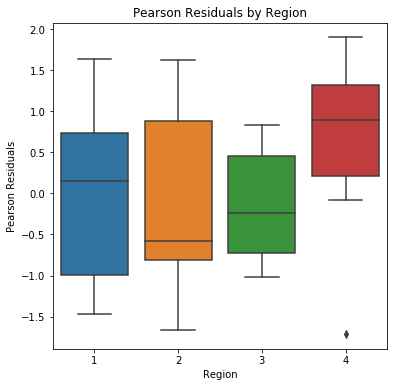

In [67]:
fig, ax = plt.subplots(figsize=(6, 6))


sns.boxplot(
    'Region', res5.resid_pearson, data=data2_clean, ax=ax
)
ax.set_title('Pearson Residuals by Region')
ax.set_ylabel('Pearson Residuals')

The Residuals vs Fitted plots are very much the same

In [89]:
def show_regression_diagnostic_plots_wls(res1):
    '''
    show_regression_diagnostic_plots_wls: show two plots to assess validity of linear regression
    
    Refer to https://web.stanford.edu/class/stats191/notebooks/Transformations_WLS.html for examples
    that guided this function
    
    Parameters
    res1: statsmodels RegressionResults value
    
    Returns
    matplotlib Figure object containing plots (one in each Axes object linked to Figure object)
    
    Notes
    In a Jupyter Notebook, calling this function will display a Figure, and also return a Figure
    Just a naked call will result in the plots being displayed twice.  To prevent this, assign
    the function call return to a variable
    
    This is intended to be called after a wls().fit() call.  No influence plots will be created,
    because these are not supported by statsmodels 
    
    Quote: The influence and outlier statistics have not been extended to other models [including wls]
    mostly for a lack of reference to the statistical literature that explicitly handles 
    this case, and for not knowing of a reference implementation in another package that 
    could be used for the unit tests.
    '''

    fig, ax = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(10, 5),
        constrained_layout=True,
    )

    # create a qq plot, to assess how (if) the residuals are distributed
    axr1c2 = ax[1]
    sm.qqplot(res1.resid, line='s', ax=axr1c2)
    axr1c2.set_title('Normal QQ Plot')

    # plot residuals against  fitted value, to see if residuals are correlated with exog variable
    # (i.e. are not normally distributed)
    axr1c1 = ax[0]
    axr1c1.plot(res1.predict(), res1.resid, 'rd')
    axr1c1.set_xlabel('Fitted Values')
    axr1c1.set_ylabel('Residuals')
    axr1c1.axhline(0, color='k')
    axr1c1.set_title('Residuals vs Fitted')

    return fig


# end

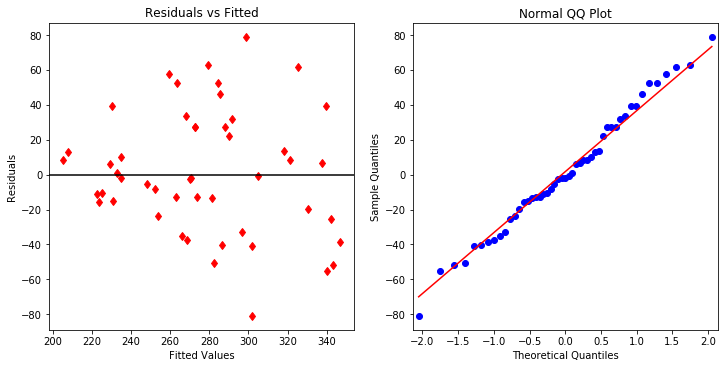

In [90]:
_ = show_regression_diagnostic_plots_wls(res5)

-----
## Environment


In [60]:
%watermark -h -iv
%watermark

seaborn     0.9.0
matplotlib  3.0.2
scipy       1.1.0
numpy       1.15.4
statsmodels 0.9.0
pandas      1.0.0
host name: DESKTOP-SODFUN6
2020-04-06T21:19:53+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


In [46]:
sm.show_versions()


INSTALLED VERSIONS
------------------
Python: 3.7.1.final.0

Statsmodels

Installed: 0.9.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\statsmodels)

Required Dependencies

cython: 0.29.2 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\Cython)
numpy: 1.15.4 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\numpy)
scipy: 1.1.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy)
pandas: 1.0.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\pandas)
    dateutil: 2.7.5 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\dateutil)
patsy: 0.5.1 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\patsy)

Optional Dependencies

matplotlib: 3.0.2 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\matplotlib)
    backend: module://ipykernel.pylab.backend_inline 
cvxopt: Not installed
joblib: 0.13.2 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\joblib)

Developer Tools

IPython: 7.2.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\IPython)
    jinja2: 2.10.1 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\jinja2)
sphinx: